In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os

In [2]:
# to modify based on the data directory
root_directory = os.getcwd().removesuffix('notebooks')
data_path = r'D:/data/glodap/'
fig_path = root_directory + '/figures/optimization/'

In [3]:
import sys
sys.path.append(root_directory + 'scripts/') # go to parent dir

import usefull_functions as uf

%load_ext autoreload
%autoreload 2

# First optimization

## Data filtering

In [7]:
glodap = pd.read_csv(data_path + 'GLODAPv2.2021_Merged_Master_File.csv', usecols=['G2latitude', 'G2longitude', 'G2pressure', 'G2depth', 'G2theta', 'G2salinity', 'G2salinityf',
                                                                                  'G2sigma2', 'G2phosphate', 'G2oxygen', 'G2phosphatef', 'G2oxygenf'])

In [8]:
glodap_selected = glodap.where((glodap['G2oxygenf'] == 2) & (glodap['G2phosphatef'] == 2) & (glodap['G2depth'] >= 1000) & (glodap['G2latitude'] <= -40)).dropna(how='all')

In [9]:
glodap_selected['PO4*'] = glodap_selected['G2phosphate'] + glodap_selected['G2oxygen']/175 - 1.95

## Find bounds

In [24]:
oxygen_gridded = xr.open_dataset(data_path + '/GLODAPv2_Mapped_Climatologies/GLODAPv2.oxygen.nc')
phosphate_gridded = xr.open_dataset(data_path + '/GLODAPv2_Mapped_Climatologies/GLODAPv2.phosphate.nc')
lon_glodap, lat_glodap = oxygen_gridded['lon'], oxygen_gridded['lat']

In [22]:
preformed_po4 = phosphate_gridded['phosphate'] + oxygen_gridded['oxygen']/175 - 1.95

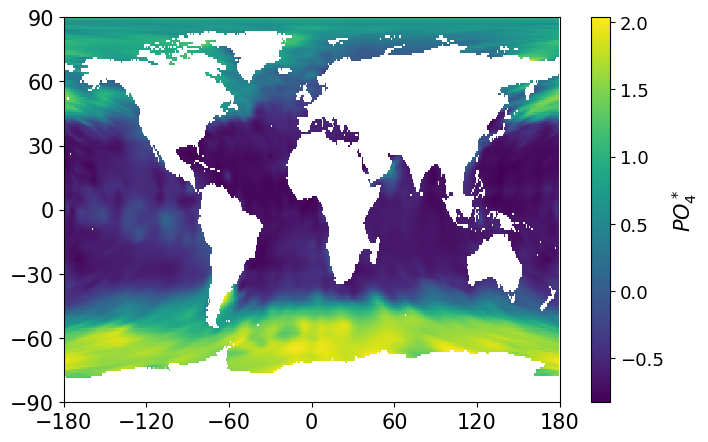

In [39]:
fig = plt.figure(figsize = (8, 5)); ax = plt.gca()

cm = uf.plt.pcolormesh(lon_glodap, lat_glodap, preformed_po4[0])
uf.plot_details_axis(ax, cm, cbarlabel='$PO_4^*$', xlim=(-180, 180), ylim = (-90, 90), 
                     yticks = [-90 + 30*i for i in range(7)], xticks = [-180 + 60*i for i in range(7)])

In [29]:
print('PO4* bound: ', np.nanmin(preformed_po4[0]), np.nanmax(preformed_po4[0]))

PO4* bound:  -0.8262461520944322 2.035549582072667


In [47]:
preformed_po4_ll = preformed_po4.where((preformed_po4['lat'] <= 30) & (preformed_po4['lat'] >= -30))
print('LL value: ', np.nanmean(preformed_po4_ll[0]), np.nanmin(preformed_po4_ll[0]), np.nanmax(preformed_po4_ll[0]))

LL value:  -0.5896525440616919 -0.8240786615173732 0.5979111296789987


In [35]:
preformed_po4_ms = preformed_po4.where((preformed_po4['lat'] <= -30) & (preformed_po4['lat'] >= -45))
print('MS value: ', np.nanmean(preformed_po4_ms[0]))

MS value:  -0.1556115763407619


In [40]:
preformed_po4_np = preformed_po4.where((preformed_po4['lat'] <= 60) & (preformed_po4['lat'] >= 30) & ((preformed_po4['lon'] <= -100) | (preformed_po4['lon'] >= 100)))
print('NP bound: ', np.nanmin(preformed_po4_np[0]), np.nanmax(preformed_po4_np[0]))

NP bound:  -0.8262461520944322 1.5420517151696342


## Optimization

In [10]:
from tracer_optimization import TracerOptimizer

In [11]:
data_path = r'D:/data/d18o_so/'
optimizer = TracerOptimizer(data_path, prepared_data=glodap_selected, lat_name = 'G2latitude', lon_name = 'G2longitude', depth_name = 'G2depth', so_compilation=False, forbidden_values=[-9999.0])

In [12]:
# Replicate the d18O optimization using the module
po4_initial_values = np.array([-0.59, -0.15, 1.49, 1.5, 0.8, 2])

# Set up the same bounds as used above
lower_bounds = np.full(6, -0.85); upper_bounds = np.full(6, 2.05)
lower_bounds[0] = -0.5901; upper_bounds[0] = -0.5899  # dyeLL fixed
upper_bounds[1] = 0.56
upper_bounds[2] = 1.5; lower_bounds[2] = 1.49
po4_bounds = (lower_bounds, upper_bounds)

# Run the complete optimization workflow
po4_optimizer = optimizer.run_complete_optimization(
    tracer_column='PO4*',
    initial_values=po4_initial_values,
    bounds=po4_bounds,
)

Loading model data...
Setting up interpolators...
Using pre-prepared tracer data...
Tracer data prepared. Final dataset contains 62069 observations.
Starting optimization for PO4*...
  Dataset 1, Model TMI: 46916 valid data points
  Dataset 1, Model OCIM: 46307 valid data points
  Dataset 1, Model NEMO: 47614 valid data points
Calculating statistics for PO4*...
Reconstructing PO4* values...
Reconstructing PO4* values...


### EM plot values

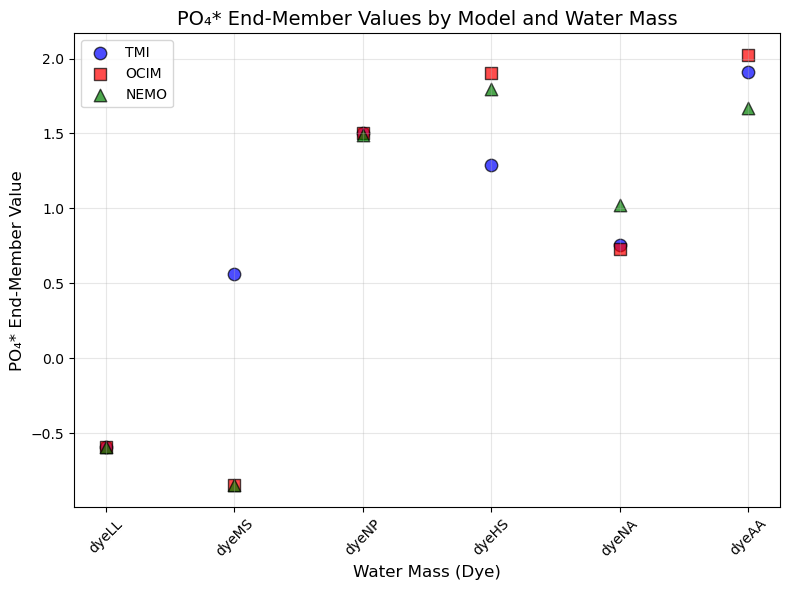

In [13]:
# Plot end-member values for PO4* across models and dyes
fig, ax = plt.subplots(figsize=(8, 6))

models = ['TMI', 'OCIM', 'NEMO']
dyes = ['dyeLL', 'dyeMS', 'dyeNP', 'dyeHS', 'dyeNA', 'dyeAA']
symbols = ['o', 's', '^']  # circle, square, triangle
colors = ['blue', 'red', 'green']

x_pos = np.arange(len(dyes))

for i, model in enumerate(models):
    mean_values = [po4_optimizer['statistics']['mean'][model][dye] for dye in dyes]
    ax.scatter(x_pos, mean_values, marker=symbols[i], s=80, 
               color=colors[i], label=model, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel('Water Mass (Dye)', fontsize=12)
ax.set_ylabel('PO₄* End-Member Value', fontsize=12)
ax.set_title('PO₄* End-Member Values by Model and Water Mass', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(dyes, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Data and reconstruction

(-0.5, 0.5)

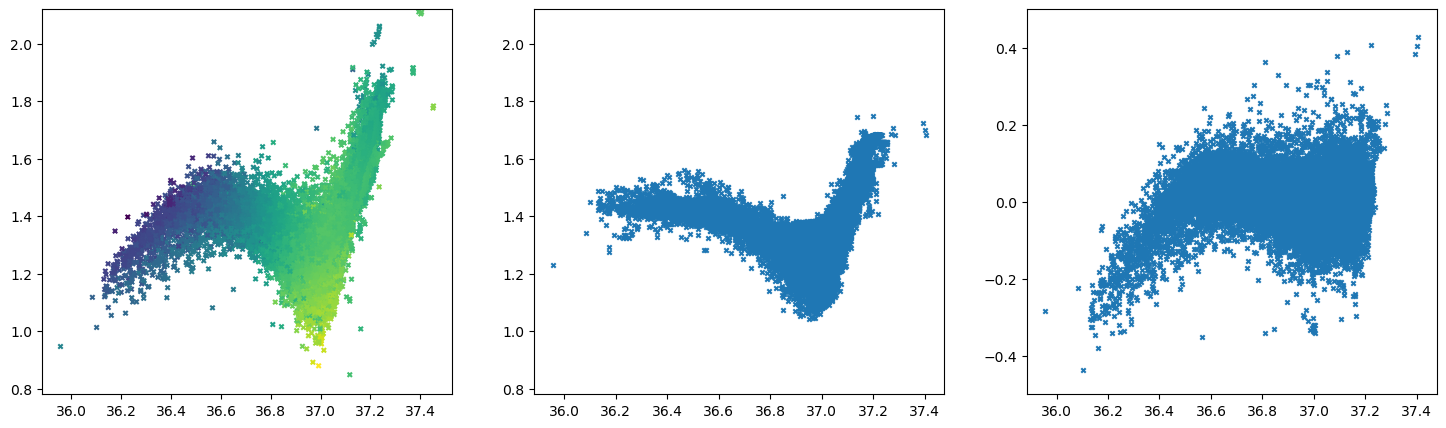

In [16]:
fig = plt.figure(figsize=(18, 5)); gs = fig.add_gridspec(1, 3)
model = 'OCIM'

ax = fig.add_subplot(gs[0, 0])
mask = po4_optimizer['datasets'][0]['G2sigma2'] != -9999.0
ax.scatter(po4_optimizer['datasets'][0]['G2sigma2'][mask], po4_optimizer['datasets'][0]['PO4*'][mask], marker='x', s=10, c = po4_optimizer['datasets'][0]['G2salinity'][mask])
ax.set_ylim(0.78, 2.12)

ax = fig.add_subplot(gs[0, 1])
ax.scatter(po4_optimizer['datasets'][0]['G2sigma2'][mask], po4_optimizer['datasets'][0][f'PO4*_rcst_mean_{model}'][mask], marker='x', s=10)
ax.set_ylim(0.78, 2.12)

ax = fig.add_subplot(gs[0, 2])
ax.scatter(po4_optimizer['datasets'][0]['G2sigma2'][mask], po4_optimizer['datasets'][0]['PO4*'][mask] - po4_optimizer['datasets'][0][f'PO4*_rcst_mean_{model}'][mask], marker='x', s=10)
ax.set_ylim(-0.5, 0.5)

In [48]:
np.nanmin(po4_optimizer['datasets'][0]['G2sigma2'])

np.float64(-9999.0)